<a href="https://colab.research.google.com/github/manjavacas/Data-Mining/blob/master/notebook/player_profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de perfiles de juego en partidas de ajedrez**

  *Minería de Datos. Curso 2019/2020.*


*   Alberto Velasco Mata
*   Diego Pedregal Hidalgo
*   Rubén Márquez Villalta
*   Antonio Manjavacas

## 1. Preproceso

In [0]:
import os
import pandas as pd

DATA_FILE = os.path.join('.', 'player_data.csv')

df = pd.read_csv(DATA_FILE, index_col=0)

FEATURES = [
    'user_id',
    'aggressiveness_mean',
    'most_common_opening',
    'maximum_elo',
    'winning_colour',
    'time_per_game_mean',
    'movements_mean',
    'points_balance_mean',
    'taken_balance_mean'
]

In [2]:
df.dtypes

user_id                 object
aggressiveness_mean    float64
most_common_opening     object
maximum_elo              int64
winning_colour          object
time_per_game_mean     float64
movements_mean         float64
points_balance_mean    float64
taken_balance_mean     float64
dtype: object

## 1.1 Codificación de las variables "most_common_opening" y "winning_colour"

In [3]:
df['winning_colour'] = df['winning_colour'].astype('category')
df['winning_colour_enc'] = df['winning_colour'].cat.codes
df['most_common_opening'] = df['most_common_opening'].astype('category')
df['most_common_opening_enc'] = df['most_common_opening'].cat.codes

df.dtypes

user_id                      object
aggressiveness_mean         float64
most_common_opening        category
maximum_elo                   int64
winning_colour             category
time_per_game_mean          float64
movements_mean              float64
points_balance_mean         float64
taken_balance_mean          float64
winning_colour_enc             int8
most_common_opening_enc        int8
dtype: object

In [4]:
df.describe()

,aggressiveness_mean,maximum_elo,time_per_game_mean,movements_mean,points_balance_mean,taken_balance_mean,winning_colour_enc,most_common_opening_enc
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,0.944645,2236.290909,937.826757,71.642424,1.472727,0.624242,0.957576,21.181818
std,0.544643,100.320585,550.667455,14.412880,1.552196,0.692746,0.202169,11.229465
min,0.000000,1500.000000,124.000000,32.000000,-2.000000,-2.000000,0.000000,0.000000
25%,0.615385,2194.000000,615.478261,63.000000,1.000000,0.000000,1.000000,9.000000
50%,0.878505,2234.000000,810.775510,71.000000,1.000000,1.000000,1.000000,25.000000
75%,1.186567,2280.000000,1105.375000,79.000000,2.000000,1.000000,1.000000,32.000000
max,4.500000,2549.000000,3651.142857,134.000000,10.000000,3.000000,1.000000,36.000000


##2. PCA

In [5]:
from sklearn import preprocessing as pre
from sklearn.decomposition import PCA

SELECTED_FEATURES = [
    'aggressiveness_mean',
    'most_common_opening_enc',
    'maximum_elo',
    'winning_colour_enc',
    'time_per_game_mean',
    'movements_mean',
    'points_balance_mean',
    'taken_balance_mean'
]

scaler = pre.MaxAbsScaler()
df_scaled = scaler.fit_transform(df[SELECTED_FEATURES])

N_COMPONENTS = 3
estimator = PCA(n_components = N_COMPONENTS)
X_pca = estimator.fit_transform(df_scaled)

print("[ Explained variance ratio ]")
print(estimator.explained_variance_ratio_)
print(sum(estimator.explained_variance_ratio_))

[ Explained variance ratio ]
[0.3753651  0.25579194 0.14913035]
0.7802873936472003


In [6]:
import numpy as np

print("[ Relation between PCA components and features ]")
print(pd.DataFrame(np.matrix.transpose(estimator.components_), columns=[f'PC-{i}' for i in range(N_COMPONENTS)], index=SELECTED_FEATURES))

[ Relation between PCA components and features ]
                             PC-0      PC-1      PC-2
aggressiveness_mean     -0.094462 -0.043957 -0.093792
most_common_opening_enc -0.968057 -0.226933  0.034489
maximum_elo              0.000002 -0.011411 -0.021827
winning_colour_enc       0.029851 -0.234845 -0.963644
time_per_game_mean      -0.026046  0.159882 -0.047032
movements_mean          -0.018137  0.090450 -0.051798
points_balance_mean      0.122322 -0.459011  0.055879
taken_balance_mean       0.192564 -0.804271  0.230020


##3. Plot

In [7]:
import plotly.express as px

scatter = pd.DataFrame(data=X_pca, index=list(range(0, len(df))), columns=['PCA0', 'PCA1', 'PCA2'])

fig = px.scatter_3d(scatter, x='PCA0', y='PCA1', z='PCA2')
fig.show()

##4. k-means

In [0]:
init = 'random'
iterations = 10
max_iter = 300
tol = 1e-04
random_state = 0

In [9]:
from sklearn.cluster import KMeans
from sklearn import metrics

k_range = range(2,35)

distortions = []
silhouettes = []

for k in k_range:
    print("k:", k)
    km = KMeans(k, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    labels = km.fit_predict(X_pca)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(X_pca, labels))

k: 2
k: 3
k: 4
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10
k: 11
k: 12
k: 13
k: 14
k: 15
k: 16
k: 17
k: 18
k: 19
k: 20
k: 21
k: 22
k: 23
k: 24
k: 25
k: 26
k: 27
k: 28
k: 29
k: 30
k: 31
k: 32
k: 33
k: 34


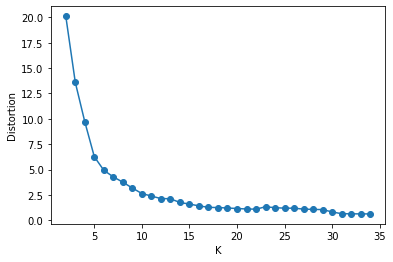

In [10]:
import matplotlib.pyplot as plt

plt.plot(k_range, distortions, marker='o')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

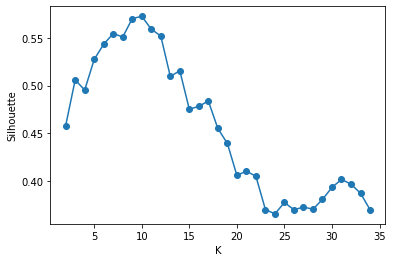

In [11]:
plt.plot(k_range, silhouettes , marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.show()

In [12]:
k = 10

km = KMeans(k, init, n_init = iterations,
            max_iter= max_iter, tol = tol, random_state = random_state)

y_km = km.fit_predict(X_pca)

print("Silhouette Coefficient: {:0.3f}".format(metrics.silhouette_score(X_pca, y_km)))
print('Distortion: {:.2f}'.format(km.inertia_))

Silhouette Coefficient: 0.573
Distortion: 2.64


In [0]:
df['group'] = km.labels_

In [14]:
import plotly.express as px

scatter = pd.DataFrame(data=X_pca, index=list(range(0, len(df))), columns=['PCA0', 'PCA1', 'PCA2'])
scatter['group'] = km.labels_

fig = px.scatter_3d(scatter, x='PCA0', y='PCA1', z='PCA2', color='group')
fig.show()

##5. Interpretación

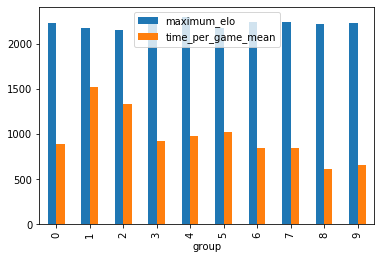

In [15]:
res = df[['maximum_elo', 'time_per_game_mean', 'group']].groupby(('group')).mean()
res.plot(kind='bar', legend=True)

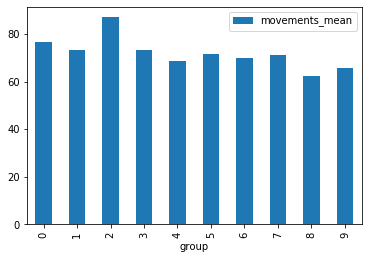

In [16]:
res = df[['movements_mean', 'group']].groupby(('group')).mean()
res.plot(kind='bar', legend=True)

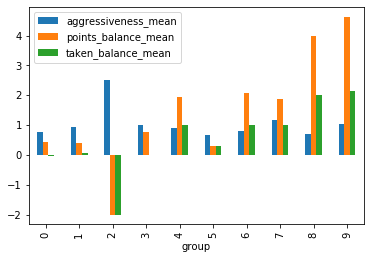

In [17]:
res = df[['aggressiveness_mean', 'points_balance_mean', 'taken_balance_mean', 'group']].groupby(('group')).mean()
res.plot(kind='bar', legend=True)

In [68]:
df[df['group'] == 2].iloc[:,2].describe()

count                    1
unique                   1
top       Sicilian Defense
freq                     1
Name: most_common_opening, dtype: object

In [69]:
df[df['group'] == 2].iloc[:,4].describe()

count         1
unique        1
top       White
freq          1
Name: winning_colour, dtype: object

In [72]:
# Outlier
df[df['group'] == 2].iloc[0,0]

'doash'